In [13]:
import numpy as np
import os
import sys
import re
import h5py
import cv2
import importlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from caiman.base.rois import register_multisession, register_ROIs

sys.path.append(r"..\..")
import paths
import processing_parameters
import functions_bondjango as bd
import functions_misc as fm
import functions_plotting as fplot
import functions_data_handling as fdh

In [2]:
importlib.reload(processing_parameters)

# get the search string
search_string = processing_parameters.search_string + r"analysistype:calciumraw"

# get the paths from the database
data_all = bd.query_database('analyzed_data', search_string)
calcium_path = [el['analysis_path'] for el in data_all]

In [86]:
def register_session(experiment_list):
    footprint_list = []
    size_list = []
    template_list = []
    
    for files in experiment_list:
        with h5py.File(files, mode='r') as f:

            try:
                calcium_data = np.array(f['A'])
            except KeyError:
                continue

            # if there are no ROIs, skip
            if (type(calcium_data) == np.ndarray) and np.any(calcium_data.astype(str) == 'no_ROIs'):
                continue
            # clear the rois that don't pass the size criteria
            areas = fm.get_roi_stats(calcium_data)[:, -1]
            keep_vector = (areas > processing_parameters.roi_parameters['area_min']) & \
                          (areas < processing_parameters.roi_parameters['area_max'])

            if np.all(keep_vector == False):
                continue

            calcium_data = calcium_data[keep_vector, :, :]

            # format and masks and store for matching

            footprint_list.append(np.moveaxis(calcium_data, 0, -1).reshape((-1, calcium_data.shape[0])))
            size_list.append(calcium_data.shape[1:])
            template_list.append(np.zeros(size_list[0]))
    
    # Run the  registration and filter the matched cells
    spatial_union, assignments, matchings = register_multisession(
        A=footprint_list, dims=size_list[0], templates=template_list, max_thr=0, thresh_cost=0.8, max_dist=13)

    n_reg = 2  # minimal number of sessions that each component has to be registered in

    # Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
    assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);

    # Use filtered indices to select the corresponding spatial components
    spatial_filtered = footprint_list[0][:, assignments_filtered[:, 0]]
    
    return assignments_filtered

In [9]:
# load the data for the matching
footprint_list = []
size_list = []
template_list = []
footprint_pics = []
rigs = []
centroids = []

# load the calcium data
for files in calcium_path:
    with h5py.File(files, mode='r') as f:

        try:
            calcium_data = np.array(f['A'])
        except KeyError:
            continue

        # if there are no ROIs, skip
        if (type(calcium_data) == np.ndarray) and np.any(calcium_data.astype(str) == 'no_ROIs'):
            continue
        # clear the rois that don't pass the size criteria
        areas = fm.get_roi_stats(calcium_data)[:, -1]
        keep_vector = (areas > processing_parameters.roi_parameters['area_min']) & \
                      (areas < processing_parameters.roi_parameters['area_max'])

        if np.all(keep_vector == False):
            continue

        calcium_data = calcium_data[keep_vector, :, :]
        
        # format and masks and store for matching
        
        footprint_list.append(np.moveaxis(calcium_data, 0, -1).reshape((-1, calcium_data.shape[0])))
        size_list.append(calcium_data.shape[1:])
        template_list.append(np.zeros(size_list[0]))
        footprint_pics.append(np.sum(calcium_data, axis=0)) #np.array(f['max_proj']))
        
        cents = []
        for cell in calcium_data:
            new_cell = cell.copy()
            new_cell[new_cell > 0] == 1 
            M = cv2.moments(new_cell)
            # centroid calciulation
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cents.append((cX, cY))

        centroids.append(cents)
        
        rig = os.path.basename(files).split('_')[6]
        rigs.append(rig)


Text(0.5, 1.0, 'Overlay')

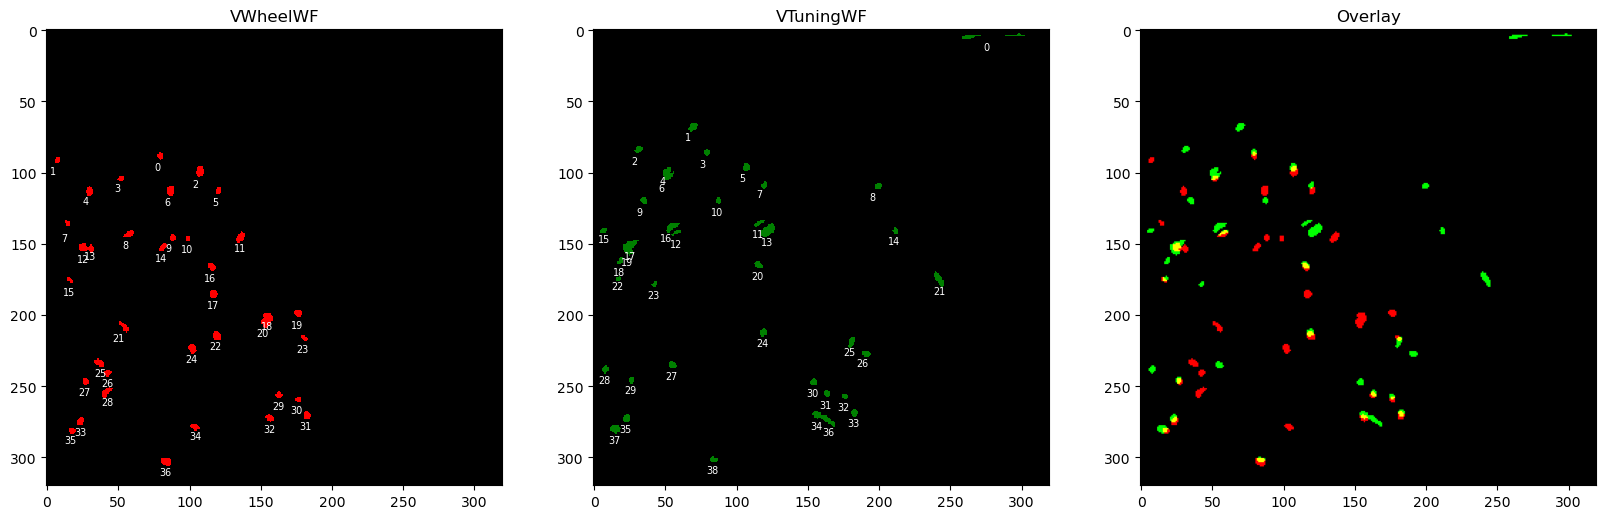

In [83]:
binary_images = []
for pic in footprint_pics:
    bin_pic = np.zeros_like(pic)
    bin_pic[pic >= 0.7] = 1
    binary_images.append(bin_pic)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
cmaps=[ListedColormap(['black','red']), ListedColormap(['black','green'])]
for i, (rig, pic, cents, cmap) in enumerate(zip(rigs, binary_images, centroids, cmaps)):
    axes[i].imshow(pic, cmap=cmap)
    axes[i].set_title(rig)
    for num, cent in enumerate(cents):
        axes[i].text(cent[0]-5, cent[1]+10, str(num), c='w', fontsize='x-small')

axes[2].imshow(np.dstack((*binary_images, np.zeros_like(binary_images[0]))))
axes[2].set_title("Overlay")

In [80]:
spatial_union, assignments, matchings = register_multisession(
        A=footprint_list, dims=size_list[0], templates=template_list, max_thr=0, thresh_cost=0.8, max_dist=13)

n_reg = 2  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);

# Use filtered indices to select the corresponding spatial components
spatial_filtered = footprint_list[0][:, assignments_filtered[:, 0]]
matched_footprints = np.sum(spatial_filtered.reshape(320, 320, spatial_filtered.shape[-1]), axis=-1)

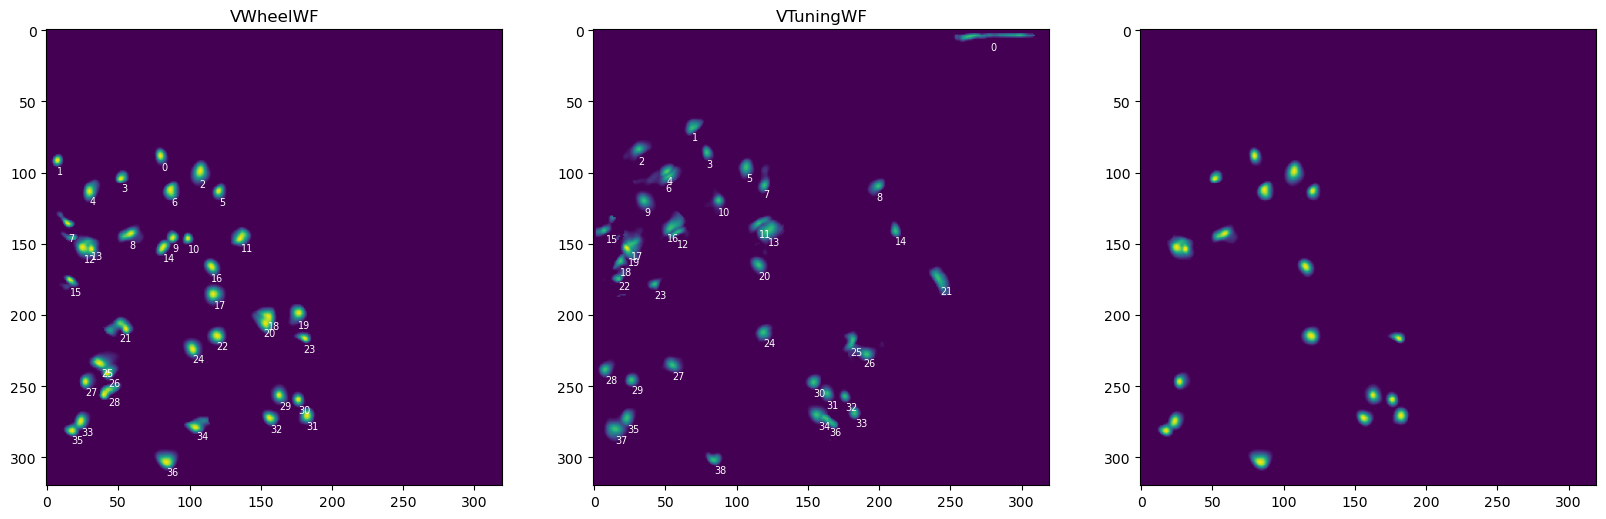

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
for i, (rig, pic, cents) in enumerate(zip(rigs, footprint_pics, centroids)):
    axes[i].imshow(pic)
    axes[i].set_title(rig)
    for num, cent in enumerate(cents):
        axes[i].text(cent[0], cent[1]+10, str(num), c='w', fontsize='x-small')
        
axes[-1] = plt.imshow(matched_footprints)

In [1]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,15))
cmaps=[ListedColormap(['black','red']), ListedColormap(['black','green'])]
for i, (rig, bin_pic, footprint, cents, cmap) in enumerate(zip(rigs, binary_images, footprint_pics, centroids, cmaps)):
    axes[0, i].imshow(footprint)
    axes[0, i].imshow(bin_pic, cmap=cmap)
    for k in range(0,2):
        axes[k, i].set_title(rig)
        for num, cent in enumerate(cents):
            axes[k, i].text(cent[0]-5, cent[1]+10, str(num), c='w', fontsize='x-small')

axes[0, -1].imshow(matched_footprints)
axes[0, -1].set_title("Matched Footprints")
            
axes[1, -1].imshow(np.dstack((*binary_images, np.zeros_like(binary_images[0]))))
axes[1, -1].set_title("Binary Overlay")

NameError: name 'plt' is not defined

In [85]:
assignments_filtered

array([[ 0,  3],
       [ 2,  5],
       [ 3,  6],
       [ 5,  7],
       [ 6, 10],
       [ 8, 12],
       [12, 19],
       [13, 17],
       [16, 20],
       [22, 24],
       [23, 25],
       [27, 29],
       [29, 31],
       [30, 32],
       [31, 33],
       [32, 34],
       [33, 35],
       [35, 37],
       [36, 38]])

In [87]:
register_session(calcium_path)

array([[ 0,  3],
       [ 2,  5],
       [ 3,  6],
       [ 5,  7],
       [ 6, 10],
       [ 8, 12],
       [12, 19],
       [13, 17],
       [16, 20],
       [22, 24],
       [23, 25],
       [27, 29],
       [29, 31],
       [30, 32],
       [31, 33],
       [32, 34],
       [33, 35],
       [35, 37],
       [36, 38]])